In [1]:
import os
os.environ['JAVA_HOME'] = '/opt/homebrew/Cellar/openjdk/22.0.2/libexec/openjdk.jdk/Contents/Home'

## Importing libraries

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Initialize spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 1 modelling")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "16g") 
    .config("spark.executor.memory", "16g")
    .config("spark.executor.cores", "2")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/08/20 17:12:21 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
data = spark.read.parquet('../data/curated/')

## Transforming data to perform regression

In [5]:
label = 'tip_amount'
    
data = data.na.fill(0) # Fix spark problem while fitting the model
            
predictors = ['trip_distance', 'fare_amount', 'tolls_amount', 'total_amount', 'airport_fee', 'trip_duration_minutes', 'tmp', 'dew', 'atm']
    
# Apply assembler
feature_columns = predictors
assembler = VectorAssembler(inputCols = feature_columns, outputCol = "predictors")
data = assembler.transform(data)

# Splitdata into train and test datasets
train_data = data.filter(F.col('pickup_date') <= '2023-11-30')
test_data = data.filter(F.col('pickup_date') >= '2023-12-01')
    

## Spliting transformed data into boroughs

In [6]:
import pandas as pd

lookup = pd.read_csv('../data/taxi_zones/taxi_zone_lookup.csv')
lookup = lookup.dropna()
boroughs = set(lookup['Borough'])

borough_data = {}

for borough in boroughs:
    borough_data[borough] = [train_data.filter(F.col('PUZone') == borough)]
    borough_data[borough].append(test_data.filter(F.col('PUZone') == borough))

Checking train and test datasets size

In [7]:
for key, item in borough_data.items():
    print(key, item[0].count(), item[1].count())

Brooklyn 128349 13880
Manhattan 22850575 2137527
Queens 2407383 199168
Bronx 35445 3889
Staten Island 1160 6
EWR 182 11


## Linear Regression 

In [8]:
def linear_regression_fit(data):
    """This function accepts a train dataset as input, fits a Linear Regression model with this dataset, and returns the model."""
    
    label = 'tip_amount'
    
    # Linear Regression fitting, LASSO
    lr = LinearRegression(featuresCol = "predictors", labelCol = label, regParam = 0.1, elasticNetParam = 1.0)
    
    lr_model = lr.fit(data)
    return lr_model


def predict_and_evaluate(model, test_data, borough): 
    """This function accepts a Linear Regression model, a test dataset and a string, borough name, as inputs, 
        predicts the test dataset, evaluates the test dataset, and return predictions"""
    
    predictions = model.transform(test_data)
    summary = model.evaluate(test_data)
    
    print(borough)
    print("Test RMSE: %f" % summary.rootMeanSquaredError)
    print("Test R2: %f" % summary.r2)
    
    return predictions
    

In [9]:
# Get the feature names to match with coefficients
feature_names = assembler.getInputCols()

for key, value in borough_data.items():
    
    train_data, test_data = value[0], value[1]
    
    # Perform Linear Regression
    linear_model = linear_regression_fit(train_data)
    predictions = predict_and_evaluate(linear_model, test_data, key)
    borough_data[key].append(predictions)
    
    # Extract the coefficients for the model
    coefficients = linear_model.coefficients
    feature_coefficients = list(zip(feature_names, coefficients))
    for feature, coefficient in feature_coefficients:
        print(f"{feature}: {coefficient}")

24/08/20 17:12:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/08/20 17:12:29 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS
24/08/20 17:12:35 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Brooklyn
Test RMSE: 1.238588
Test R2: 0.906261
trip_distance: -0.051830703079592255
fare_amount: -0.5443334318216667
tolls_amount: -0.5863518365238028
total_amount: 0.6054355994689725
airport_fee: 0.0
trip_duration_minutes: -0.01755703256243488
tmp: 0.0
dew: 0.0
atm: 0.0


Manhattan
Test RMSE: 1.619997
Test R2: 0.686535
trip_distance: 0.0
fare_amount: 0.0
tolls_amount: 0.0
total_amount: 0.14928743930745728
airport_fee: 0.0
trip_duration_minutes: 0.0
tmp: 0.0
dew: 0.0
atm: 0.0


Queens
Test RMSE: 2.278059
Test R2: 0.845590
trip_distance: 0.0
fare_amount: -0.4911856048262145
tolls_amount: -0.6868242600986298
total_amount: 0.5993377041038438
airport_fee: -0.9687013895716717
trip_duration_minutes: -0.005139759863084699
tmp: 0.0
dew: 0.0
atm: 0.0


Bronx
Test RMSE: 1.119263
Test R2: 0.587217
trip_distance: -0.05411393769682416
fare_amount: -0.30629075799479333
tolls_amount: -0.3506510710200275
total_amount: 0.35748761516934086
airport_fee: 0.0
trip_duration_minutes: -0.011817342835410128
tmp: 0.0
dew: 0.0
atm: 0.0


Staten Island
Test RMSE: 2.458300
Test R2: 0.894181
trip_distance: -0.04147306881022963
fare_amount: -0.6735686465873599
tolls_amount: -0.7239525890995463
total_amount: 0.7134751219359174
airport_fee: 0.0
trip_duration_minutes: -0.006620894704435028
tmp: 0.0
dew: 0.0
atm: 0.0


EWR
Test RMSE: 2.024168
Test R2: 0.953304
trip_distance: -0.0466642346667316
fare_amount: -0.8548601907161599
tolls_amount: -0.8214679810400365
total_amount: 0.875477730696067
airport_fee: 0.0
trip_duration_minutes: -0.0019055739649013854
tmp: -0.0020587309161325625
dew: 0.0
atm: 0.0


## Random Forest Regression

In [10]:
def random_forest_regression_fit(data):
    """This function accepts a train dataset as input, fits a Random Forest Regression model with this dataset, and returns the model."""
    
    label = 'tip_amount'
    
    # Random Forest fitting
    rf = RandomForestRegressor(featuresCol = "predictors", labelCol=label)
    
    rf_model = rf.fit(data)
    return rf_model

def evaluate(predictions):
    """This function accepts a predictions dataframe and evaluates those predictions"""    

    evaluator_rmse = RegressionEvaluator(
        labelCol = "tip_amount", 
        predictionCol = "prediction", 
        metricName = "rmse"
    )
    rmse = evaluator_rmse.evaluate(predictions)
    print(f"Root Mean Squared Error (RMSE): {rmse}")

    evaluator_r2 = RegressionEvaluator(
            labelCol = 'tip_amount', 
            predictionCol = "prediction", 
            metricName = "r2"
        )
    r2 = evaluator_r2.evaluate(predictions)
    print(f"R2: {r2}")

In [11]:
# Get the feature names to match with importances
feature_names = assembler.getInputCols()

for key, value in borough_data.items():
    
    train_data, test_data = value[0], value[1]
    
    # Perform Random Forest Regresison
    rf_model = random_forest_regression_fit(train_data)
    print(key)
    predictions = rf_model.transform(test_data)
    evaluate(predictions)
    borough_data[key].append(predictions)
    
    # Extract the importances of features for the model
    importances = rf_model.featureImportances
    feature_importances = list(zip(feature_names, importances))
    for feature, importance in feature_importances:
        print(f"{feature}: {importance}")

Brooklyn


Root Mean Squared Error (RMSE): 2.813839640467843


R2: 0.516201905751756
trip_distance: 0.07399958938965083
fare_amount: 0.19833053115535018
tolls_amount: 0.0314037768007474
total_amount: 0.5126930269637114
airport_fee: 0.001453210492930856
trip_duration_minutes: 0.17718557264389395
tmp: 0.003167050374995541
dew: 0.0011647169331120988
atm: 0.0006025252456078586


Manhattan


Root Mean Squared Error (RMSE): 1.7172143366359012


R2: 0.6477839377813255
trip_distance: 0.19790276043873875
fare_amount: 0.24029676220712068
tolls_amount: 0.11872966125146252
total_amount: 0.36141529807581163
airport_fee: 0.0
trip_duration_minutes: 0.08155118703213267
tmp: 4.35043103780264e-05
dew: 3.517984027550177e-05
atm: 2.564684408022649e-05


Queens


Root Mean Squared Error (RMSE): 3.5106454003602527


R2: 0.633292122596704
trip_distance: 0.1363352826836469
fare_amount: 0.16046346617573684
tolls_amount: 0.03800184251530857
total_amount: 0.5950311966123993
airport_fee: 0.013903095237300767
trip_duration_minutes: 0.05601520124568049
tmp: 0.00018153888433564342
dew: 6.74173696990678e-05
atm: 9.592758922322184e-07


Bronx


Root Mean Squared Error (RMSE): 1.345962441119931


R2: 0.40307106538460347
trip_distance: 0.14729391587623158
fare_amount: 0.2159906063596476
tolls_amount: 0.06149523529764245
total_amount: 0.4024662663353391
airport_fee: 0.00853008479256306
trip_duration_minutes: 0.11931319725286364
tmp: 0.026079316481975846
dew: 0.008828639820548965
atm: 0.010002737783187702


Staten Island


Root Mean Squared Error (RMSE): 2.7474386368275496


R2: 0.867825258808725
trip_distance: 0.04470616756727869
fare_amount: 0.40168293637427605
tolls_amount: 0.05752256249644144
total_amount: 0.34344275985502776
airport_fee: 0.0
trip_duration_minutes: 0.06190274647246032
tmp: 0.037741151901521316
dew: 0.025867955609686095
atm: 0.02713371972330848


EWR


Root Mean Squared Error (RMSE): 6.767167775324343


R2: 0.4780882816922407
trip_distance: 0.09061178919567776
fare_amount: 0.13234143834103135
tolls_amount: 0.08739461877130653
total_amount: 0.3296340433803141
airport_fee: 0.0
trip_duration_minutes: 0.15186527591477045
tmp: 0.05731000382849254
dew: 0.0925432285962223
atm: 0.05829960197218498


## Actual vs Linear Regression vs Random Forest Regresison visualisation

In [12]:
mean_tip_data = []

for key, value in borough_data.items():
    avg_actual = value[1].select('tip_amount').rdd.flatMap(lambda x: x).mean()
    avg_linear_pred = value[2].select('prediction').rdd.flatMap(lambda x: x).mean()
    avg_rf_pred = value[3].select('prediction').rdd.flatMap(lambda x: x).mean()
    mean_tip_data.append([avg_actual, avg_linear_pred, avg_rf_pred])

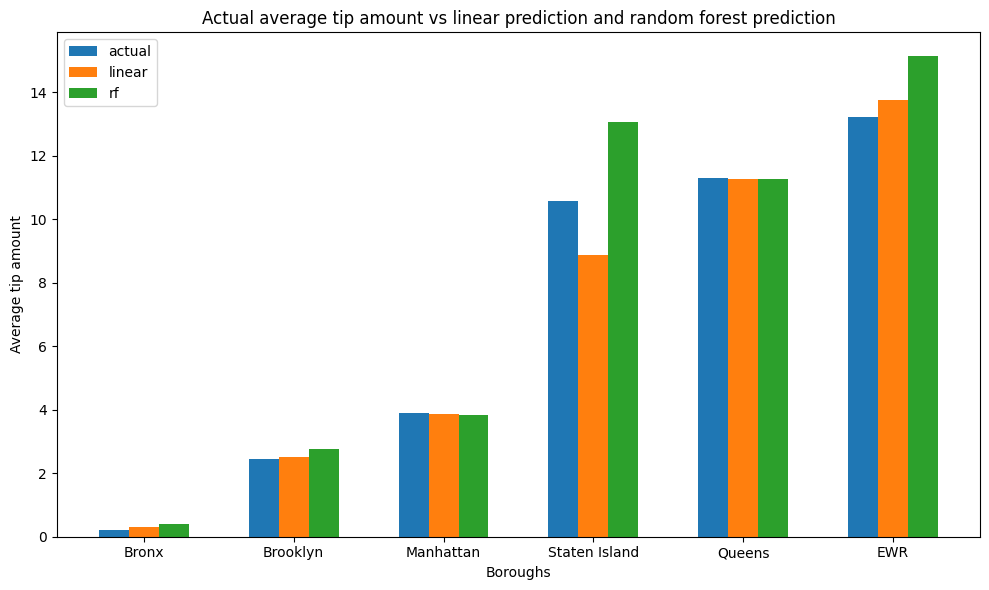

In [14]:
labels = list(borough_data.keys())
columns = ['actual', 'linear', 'rf']

# Sort the data by actual avg_tip_amount
sorted_data = sorted(zip(labels, mean_tip_data), key=lambda x: x[1][0])
labels, mean_tip_data = zip(*sorted_data)

n_areas = len(mean_tip_data)
n_columns = len(columns)

x = np.arange(n_areas)
width = 0.2 

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_columns):
    ax.bar(x + i * width, [area[i] for area in mean_tip_data], width, label=columns[i])

ax.set_xlabel('Boroughs')
ax.set_ylabel('Average tip amount')
ax.set_title('Actual average tip amount vs linear prediction and random forest prediction')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.savefig('../plots/bar_chart_tip_amount')
plt.show()


In [ ]:
avg_tip_per_mile = []

for key, value in borough_data.items():
    total_dist = value[1].select('trip_distance').rdd.flatMap(lambda x: x).sum()
    avg_actual = value[1].select('tip_amount').rdd.flatMap(lambda x: x).sum()/total_dist
    avg_linear_pred = value[2].select('prediction').rdd.flatMap(lambda x: x).sum()/total_dist
    avg_rf_pred = value[3].select('prediction').rdd.flatMap(lambda x: x).sum()/total_dist
    avg_tip_per_mile.append([avg_actual, avg_linear_pred, avg_rf_pred])

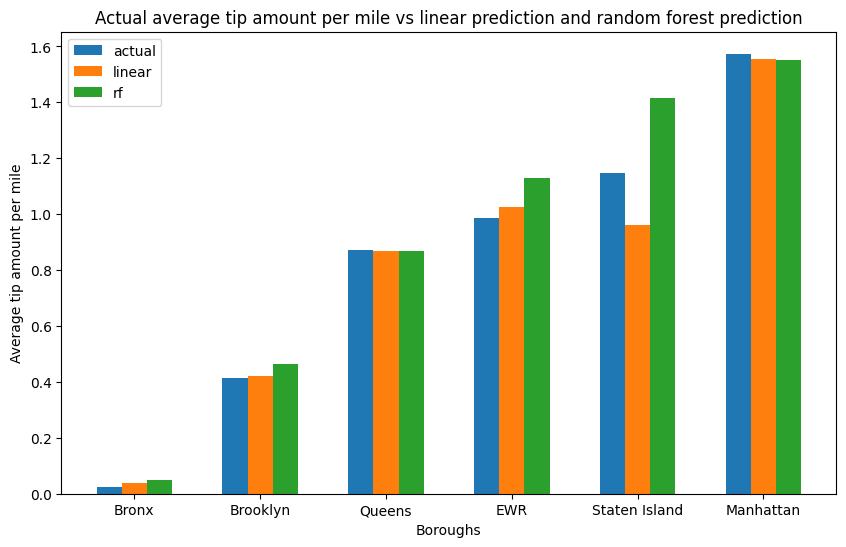

In [15]:
labels = list(borough_data.keys())
columns = ['actual', 'linear', 'rf']

# Sort the data by actual avg_tip_per_mile
sorted_data = sorted(zip(labels, avg_tip_per_mile), key=lambda x: x[1][0])
labels, avg_tip_per_mile = zip(*sorted_data)

n_areas = len(avg_tip_per_mile)
n_columns = len(columns)

x = np.arange(n_areas)
width = 0.2  

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(n_columns):
    ax.bar(x + i * width, [area[i] for area in avg_tip_per_mile], width, label=columns[i])

ax.set_xlabel('Boroughs')
ax.set_ylabel('Average tip amount per mile')
ax.set_title('Actual average tip amount per mile vs linear prediction and random forest prediction')
ax.set_xticks(x + width)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout
plt.savefig('../plots/bar_chart_tip_per_mile_amount')
plt.show()